## ESA CCI Toolbox Reproject Dataset

The purpose of this notebook is to demonstrate how to access a dataset, resample it to different coordinates, and reproject it to a new coordinate reference system (CRS).

To run this Notebook, make sure the ESA CCI Toolbox is setup correctly.

The ESA CCI Toolbox is built on xcube, leveraging many of its functionalities in this notebook. For additional examples on resampling and reprojection, visit the [xcube GitHub repository](https://github.com/xcube-dev/xcube/tree/main/examples/notebooks/resampling).

In [1]:
from xcube.core.gridmapping import GridMapping
from xcube.core.resampling import resample_in_space
from xcube.core.store import new_data_store

---
### Reproject Dataset from ESA Open Data Portal

To access datasets from the ESA Open Data Portal store, we begin by initializing a new data store using the store ID 'esa-cci'.

In [2]:
cci_store = new_data_store('esa-cci')

<frozen abc>:106: FutureWarning: xarray subclass VectorDataCube should explicitly define __slots__


All provided data are datasets. So, let's have a look what data sets are available. 

In [3]:
datasets = cci_store.list_data_ids()
datasets

['esacci.AEROSOL.5-days.L3C.AEX.GOMOS.Envisat.AERGOM.3-00.r1',
 'esacci.AEROSOL.climatology.L3.AAI.multi-sensor.multi-platform.MSAAI.1-7.r1',
 'esacci.AEROSOL.day.L3.AAI.multi-sensor.multi-platform.MSAAI.1-7.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.AATSR.Envisat.ADV.2-31.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.AATSR.Envisat.ORAC.04-01-.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.AATSR.Envisat.ORAC.04-01_seg-.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.AATSR.Envisat.SU.4-3.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.ATSR-2.ERS-2.ADV.2-31.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.ATSR-2.ERS-2.ORAC.04-01-.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.ATSR-2.ERS-2.ORAC.04-01_seg-.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.ATSR-2.ERS-2.SU.4-3.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.multi-sensor.multi-platform.AATSR-ENVISAT-ENS_DAILY.v2-6.r1',
 'esacci.AEROSOL.day.L3C.AER_PRODUCTS.multi-sensor.multi-platform.ATSR2-ENVISAT-ENS_DAILY.v2-6.r1',
 'esacci.AEROSOL.day.L3C.AOD.MERIS.Envisat.MERI

We would like to reproject the CCI Biomass map where we select the finest resolution available at 1,000m. But first we view the available opening parameters for the respective dataset. 

In [4]:
cci_store.get_open_data_params_schema(
    data_id='esacci.BIOMASS.yr.L4.AGB.multi-sensor.multi-platform.MERGED.5-0.1000m'
)

/home/konstantin/bc_kon/01_coding/01_github/xcube-cci/xcube_cci/cciodp.py:2043: CciOdpWarning: Variable "crs" has no fill value, cannot set one. For parts where no data is available you will see random values. This is usually the case when data is missing for a time step.
  warnings.warn(f'Variable "{fixed_key}" has no fill value, '


Now we can open the dataset and select a subset with covers Europe.

In [5]:
ds = cci_store.open_data(
    'esacci.BIOMASS.yr.L4.AGB.multi-sensor.multi-platform.MERGED.5-0.1000m'
)
ds = ds.sel(lat=slice(60, 45), lon=slice(0, 20))
ds

<xarray.Dataset> Size: 192MB
Dimensions:    (time: 8, lat: 1500, lon: 2000, nv: 2, bnds: 2)
Coordinates:
  * lat        (lat) float64 12kB 59.99 59.98 59.98 59.96 ... 45.02 45.01 45.0
    lat_bnds   (lat, nv) float64 24kB dask.array<chunksize=(1500, 2), meta=np.ndarray>
  * lon        (lon) float64 16kB 0.005 0.015 0.025 0.035 ... 19.97 19.99 20.0
    lon_bnds   (lon, nv) float64 32kB dask.array<chunksize=(2000, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 64B 2010-01-01 2015-01-01 ... 2021-01-01
    time_bnds  (time, bnds) datetime64[ns] 128B dask.array<chunksize=(8, 2), meta=np.ndarray>
Dimensions without coordinates: nv, bnds
Data variables:
    agb        (time, lat, lon) float32 96MB dask.array<chunksize=(8, 600, 720), meta=np.ndarray>
    agb_sd     (time, lat, lon) float32 96MB dask.array<chunksize=(8, 600, 720), meta=np.ndarray>
    crs        <U0 0B ...
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.BIOMASS.yr.L4.AGB.multi-sensor.multi-plat...
    date_created:            2025-03-18T20:50:55.449314
    processing_level:        L4
    time_coverage_start:     2010-01-01T00:00:00
    time_coverage_end:       2021-01-01T00:00:00
    time_coverage_duration:  P4018DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

We can plot the above ground biomass in the original projection before reprojecting it. 

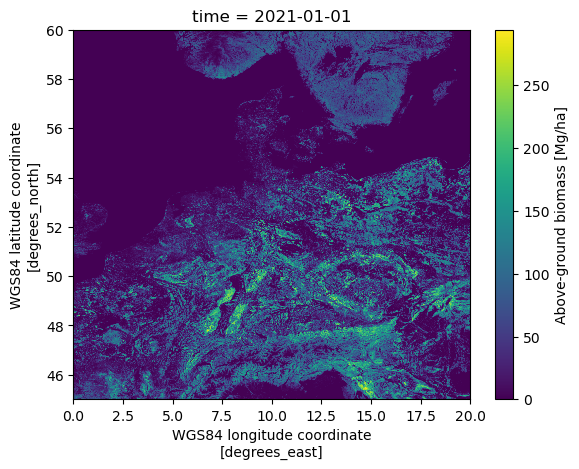

In [6]:
ds.agb.isel(time=-1).plot()

Now, we can reproject the dataset from the original Geographic Coordinate System (EPSG:4326 - WGS 84) to the European Projected Coordinate System (EPSG:3035). To achieve this, we first create a grid mapping that defines the target projection, which is then used to reproject the dataset.  

In [7]:
source_gm = GridMapping.from_dataset(ds)
temp_target_gm = source_gm.transform("EPSG:3035", xy_res=1000)
target_gm = temp_target_gm.to_regular()
target_gm

class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:3035
* xy_res: (1000, 1000)
* xy_bbox: (3533353, 2431533, 5109353, 4140533)
* ij_bbox: (0, 0, 1576, 1709)
* xy_dim_names: ('x', 'y')
* xy_var_names: ('x', 'y')
* size: (1576, 1709)
* tile_size: (720, 720)

In [8]:
ds_reproject = resample_in_space(
    ds,
    source_gm=source_gm,
    target_gm=target_gm,
)
ds_reproject

<xarray.Dataset> Size: 172MB
Dimensions:  (time: 8, y: 1709, x: 1576, bnds: 2)
Coordinates:
  * time     (time) datetime64[ns] 64B 2010-01-01 2015-01-01 ... 2021-01-01
  * y        (y) float64 14kB 4.14e+06 4.139e+06 ... 2.433e+06 2.432e+06
  * x        (x) float64 13kB 3.534e+06 3.535e+06 ... 5.108e+06 5.109e+06
    x_bnds   (x, bnds) float64 25kB 3.533e+06 3.534e+06 ... 5.108e+06 5.109e+06
    y_bnds   (y, bnds) float64 27kB 4.141e+06 4.14e+06 ... 2.433e+06 2.432e+06
Dimensions without coordinates: bnds
Data variables:
    agb      (time, y, x) float32 86MB dask.array<chunksize=(8, 720, 720), meta=np.ndarray>
    agb_sd   (time, y, x) float32 86MB dask.array<chunksize=(8, 720, 720), meta=np.ndarray>
    crs      int64 8B 0
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.BIOMASS.yr.L4.AGB.multi-sensor.multi-plat...
    date_created:            2025-03-18T20:50:55.449314
    processing_level:        L4
    time_coverage_start:     2010-01-01T00:00:00
    time_coverage_end:       2021-01-01T00:00:00
    time_coverage_duration:  P4018DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

Al last, we can plot the one time step as an example.

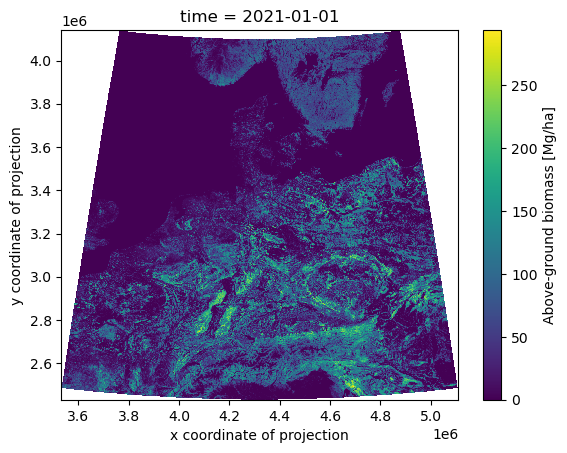

In [9]:
ds_reproject.agb.isel(time=-1).plot()